# Text Mining and Sentiment Analysis for Hotel Reviews of TripAdvisor

## load the lobraries 

In [4]:
install.packages('igraph')
install.packages('ggraph')

Installing package into 'C:/Users/sxw17/Documents/R/win-library/3.5'
(as 'lib' is unspecified)

Warning message:
"package 'igraph' is in use and will not be installed"
Installing package into 'C:/Users/sxw17/Documents/R/win-library/3.5'
(as 'lib' is unspecified)

also installing the dependencies 'farver', 'tweenr', 'polyclip', 'RcppArmadillo', 'ggforce', 'ggrepel', 'tidygraph', 'graphlayouts'




package 'farver' successfully unpacked and MD5 sums checked
package 'tweenr' successfully unpacked and MD5 sums checked
package 'polyclip' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'ggforce' successfully unpacked and MD5 sums checked
package 'ggrepel' successfully unpacked and MD5 sums checked
package 'tidygraph' successfully unpacked and MD5 sums checked
package 'graphlayouts' successfully unpacked and MD5 sums checked
package 'ggraph' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\sxw17\AppData\Local\Temp\RtmpMLKbHs\downloaded_packages


In [10]:
library(dplyr)
library(readr)
library(lubridate)
library(ggplot2)
library(tidytext)
library(tidyverse)
library(stringr)
library(tidyr)
library(scales)
library(broom)
library(purrr)
library(widyr)
library(igraph)
library(ggraph)
library(SnowballC)
library(wordcloud)
library(reshape2)
theme_set(theme_minimal())

## The Data

In [11]:
df <- read_csv("hotel_reviews.csv")
df <- df[complete.cases(df), ]
df$review_date <- as.Date(df$review_date, format = "%d-%B-%y")
dim(df); min(df$review_date); max(df$review_date)

Parsed with column specification:
cols(
  review_body = col_character(),
  review_date = col_character()
)



[1] 13701     2

[1] "2002-03-21"

[1] "2018-08-02"

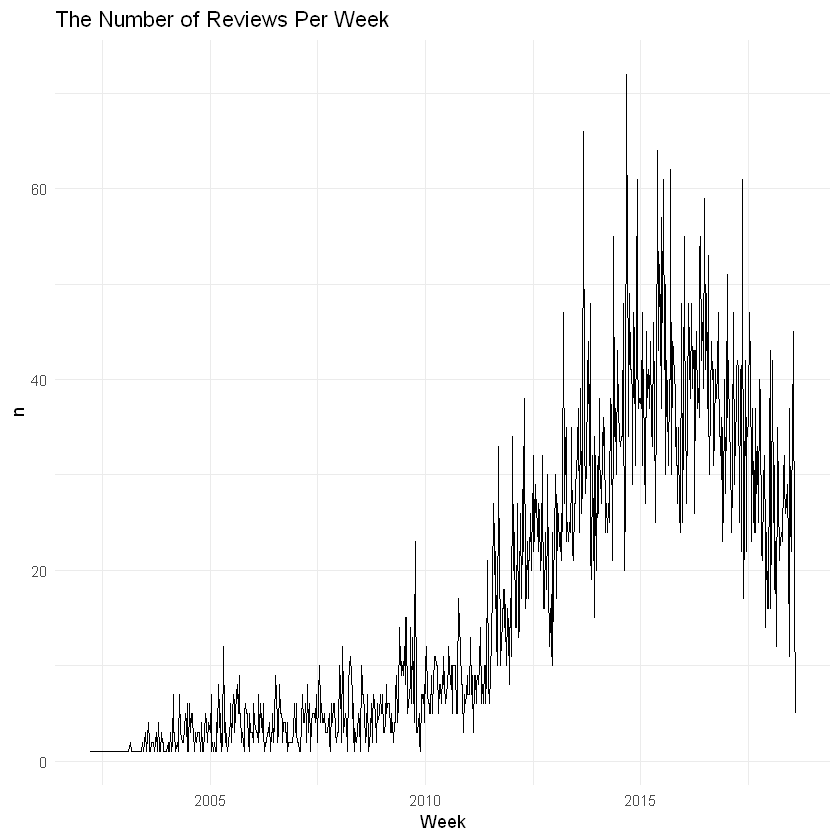

In [12]:
df %>%
  count(Week = round_date(review_date, "week")) %>%
  ggplot(aes(Week, n)) +
  geom_line() + 
  ggtitle('The Number of Reviews Per Week')

## Text Mining of the Review Text

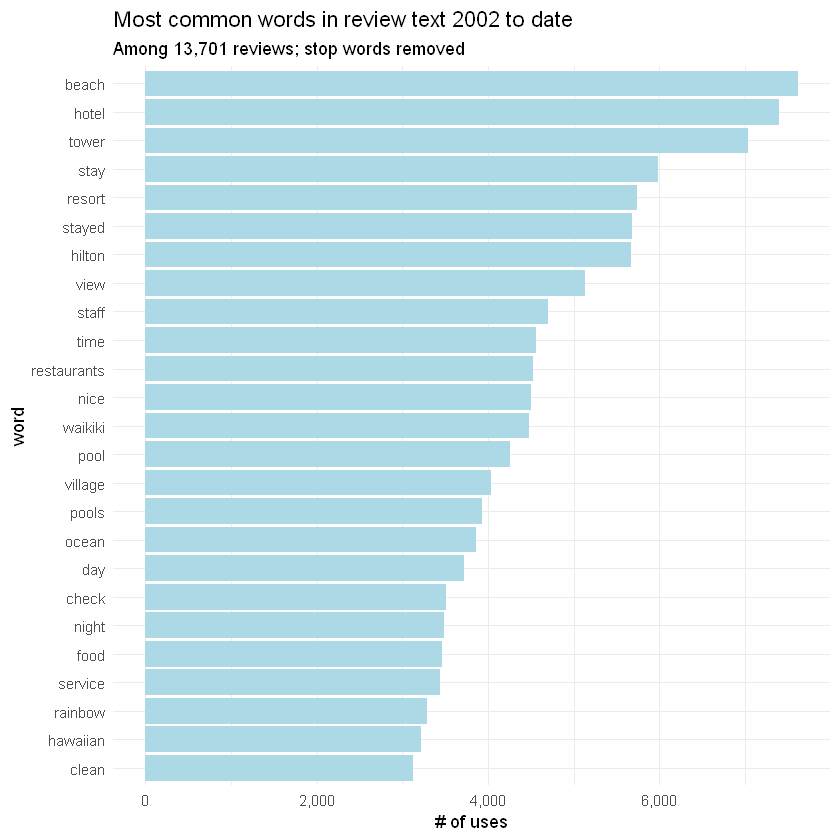

In [13]:
df <- tibble::rowid_to_column(df, "ID")
df <- df %>%
  mutate(review_date = as.POSIXct(review_date, origin = "1970-01-01"),month = round_date(review_date, "month"))
review_words <- df %>%
  distinct(review_body, .keep_all = TRUE) %>%
  unnest_tokens(word, review_body, drop = FALSE) %>%
  distinct(ID, word, .keep_all = TRUE) %>%
  anti_join(stop_words, by = "word") %>%
  filter(str_detect(word, "[^\\d]")) %>%
  group_by(word) %>%
  mutate(word_total = n()) %>%
  ungroup()
word_counts <- review_words %>%
  count(word, sort = TRUE)
word_counts %>%
  head(25) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col(fill = "lightblue") +
  scale_y_continuous(labels = comma_format()) +
  coord_flip() +
  labs(title = "Most common words in review text 2002 to date",
       subtitle = "Among 13,701 reviews; stop words removed",
       y = "# of uses")


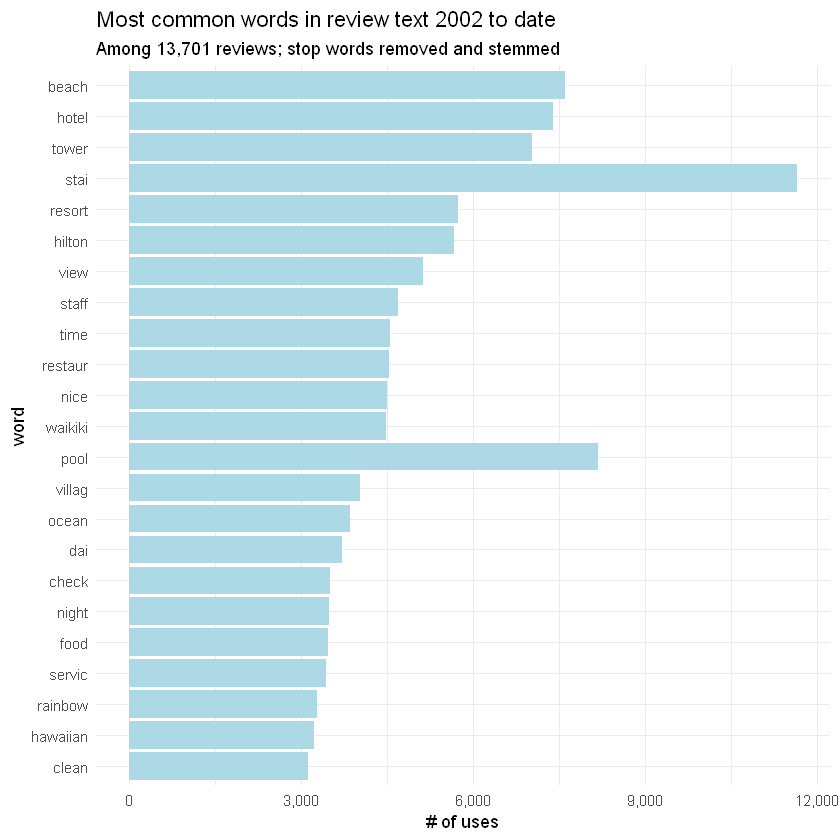

In [14]:
word_counts %>%
  head(25) %>%
  mutate(word = wordStem(word)) %>% 
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col(fill = "lightblue") +
  scale_y_continuous(labels = comma_format()) +
  coord_flip() +
  labs(title = "Most common words in review text 2002 to date",
       subtitle = "Among 13,701 reviews; stop words removed and stemmed",
       y = "# of uses")

### Bigrams

In [15]:
review_bigrams <- df %>%
  unnest_tokens(bigram, review_body, token = "ngrams", n = 2)
bigrams_separated <- review_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")
bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE)
bigrams_united <- bigrams_filtered %>%
  unite(bigram, word1, word2, sep = " ")
bigrams_united %>%
  count(bigram, sort = TRUE)

bigram,n
<chr>,<int>
rainbow tower,3568
hawaiian village,2909
hilton hawaiian,2821
ocean view,2332
diamond head,2180
waikiki beach,1710
tapa tower,1625
ali'i tower,1583
front desk,1328


Joining, by = "word"

Warning message:
"`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session."
Joining, by = "word"



List of 28
 $ line                      : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ rect                      : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ text                      :List of 11
  ..$ family       : chr ""
  ..$ face         : chr "plain"
  ..$ colour       : chr "black"
  ..$ size         : num 11
  ..$ hjust        : num 0.5
  ..$ vjust        : num 0.5
  ..$ angle        : num 0
  ..$ lineheight   : num 0.9
  ..$ margin       : 'margin' num [1:4] 0pt 0pt 0pt 0pt
  .. ..- attr(*, "valid.unit")= int 8
  .. ..- attr(*, "unit")= chr "pt"
  ..$ debug        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.title                : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.text                 : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.ticks.length         : 'unit' num 0pt
  ..- attr(*, "valid.un

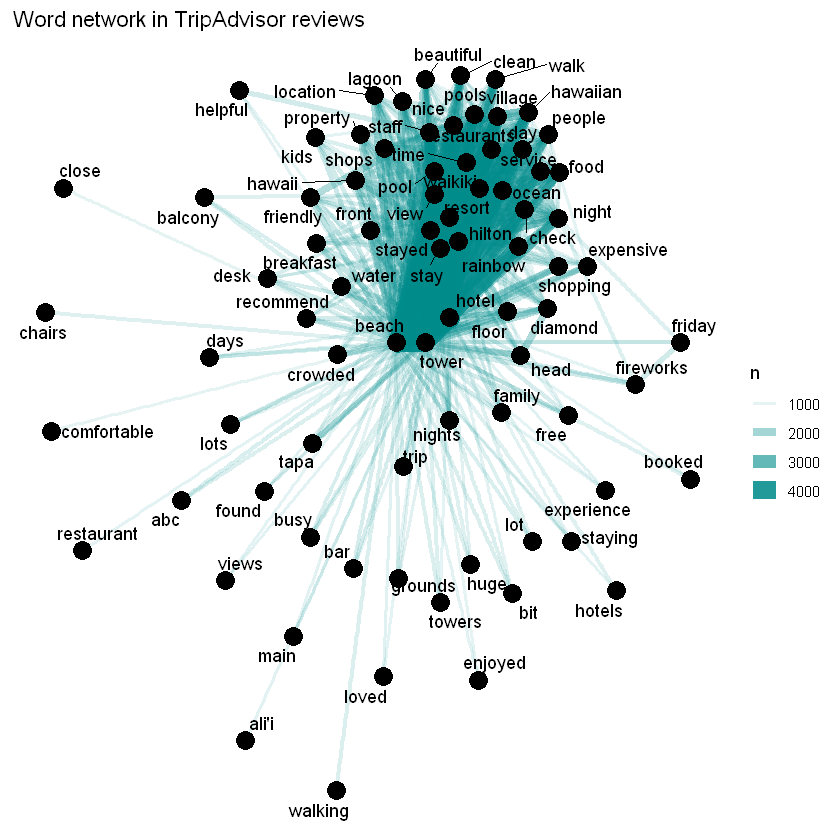

In [16]:
review_subject <- df %>% 
  unnest_tokens(word, review_body) %>% 
  anti_join(stop_words)
my_stopwords <- data_frame(word = c(as.character(1:10)))
review_subject <- review_subject %>% 
  anti_join(my_stopwords)
title_word_pairs <- review_subject %>% 
  pairwise_count(word, ID, sort = TRUE, upper = FALSE)
set.seed(1234)
title_word_pairs %>%
  filter(n >= 1000) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "cyan4") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, 
                 point.padding = unit(0.2, "lines")) +
  ggtitle('Word network in TripAdvisor reviews')
  theme_void()

### Trigrams

In [18]:
review_trigrams <- df %>%
  unnest_tokens(trigram, review_body, token = "ngrams", n = 3)

trigrams_separated <- review_trigrams %>%
  separate(trigram, c("word1", "word2", "word3"), sep = " ")

trigrams_filtered <- trigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>%
  filter(!word3 %in% stop_words$word)

trigram_counts <- trigrams_filtered %>% 
  count(word1, word2, word3, sort = TRUE)

trigrams_united <- trigrams_filtered %>%
  unite(trigram, word1, word2, word3, sep = " ")

trigrams_united %>%
  count(trigram, sort = TRUE)

trigram,n
<chr>,<int>
hilton hawaiian village,2614
diamond head tower,575
partial ocean view,389
ala moana shopping,365
friday night fireworks,358
round table pizza,205
moana shopping centre,171
ala moana mall,147
front desk staff,144


### Important words trending in reviews

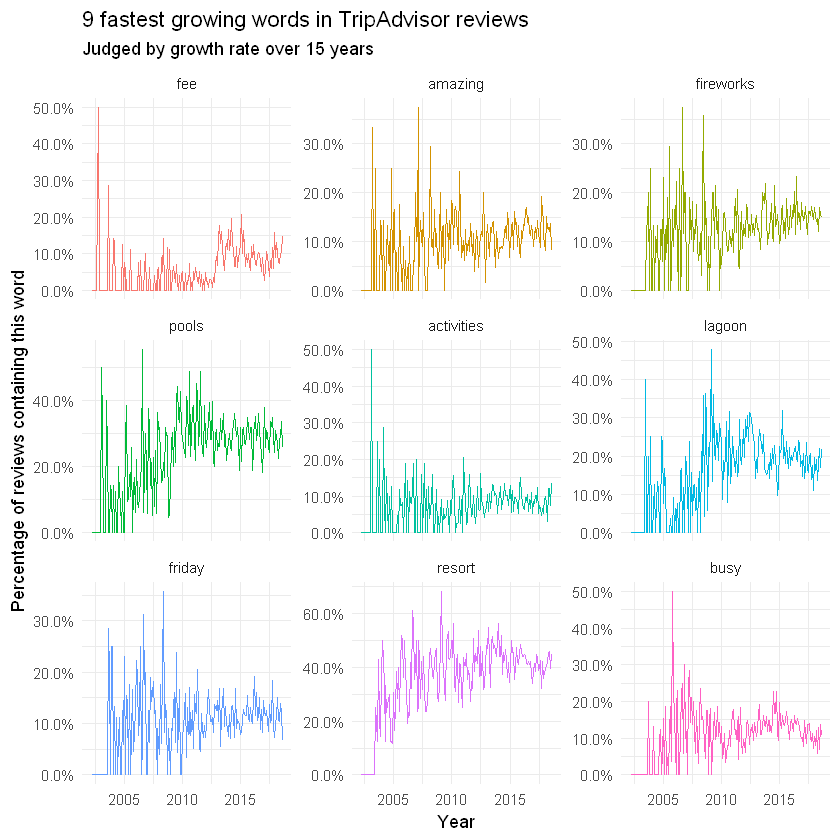

In [19]:
reviews_per_month <- df %>%
  group_by(month) %>%
  summarize(month_total = n())
word_month_counts <- review_words %>%
  filter(word_total >= 1000) %>%
  count(word, month) %>%
  complete(word, month, fill = list(n = 0)) %>%
  inner_join(reviews_per_month, by = "month") %>%
  mutate(percent = n / month_total) %>%
  mutate(year = year(month) + yday(month) / 365)
mod <- ~ glm(cbind(n, month_total - n) ~ year, ., family = "binomial")
slopes <- word_month_counts %>%
  nest(-word) %>%
  mutate(model = map(data, mod)) %>%
  unnest(map(model, tidy)) %>%
  filter(term == "year") %>%
  arrange(desc(estimate))
slopes %>%
  head(9) %>%
  inner_join(word_month_counts, by = "word") %>%
  mutate(word = reorder(word, -estimate)) %>%
  ggplot(aes(month, n / month_total, color = word)) +
  geom_line(show.legend = FALSE) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(~ word, scales = "free_y") +
  expand_limits(y = 0) +
  labs(x = "Year",
       y = "Percentage of reviews containing this word",
       title = "9 fastest growing words in TripAdvisor reviews",
       subtitle = "Judged by growth rate over 15 years")

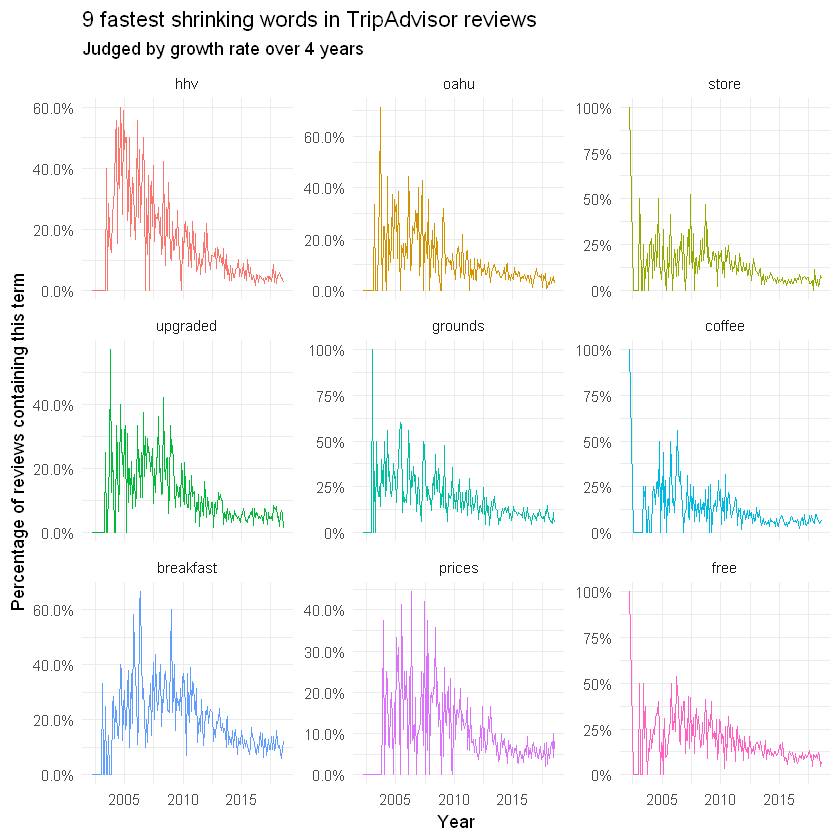

In [20]:
slopes %>%
  tail(9) %>%
  inner_join(word_month_counts, by = "word") %>%
  mutate(word = reorder(word, estimate)) %>%
  ggplot(aes(month, n / month_total, color = word)) +
  geom_line(show.legend = FALSE) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(~ word, scales = "free_y") +
  expand_limits(y = 0) +
  labs(x = "Year",
       y = "Percentage of reviews containing this term",
       title = "9 fastest shrinking words in TripAdvisor reviews",
       subtitle = "Judged by growth rate over 4 years")

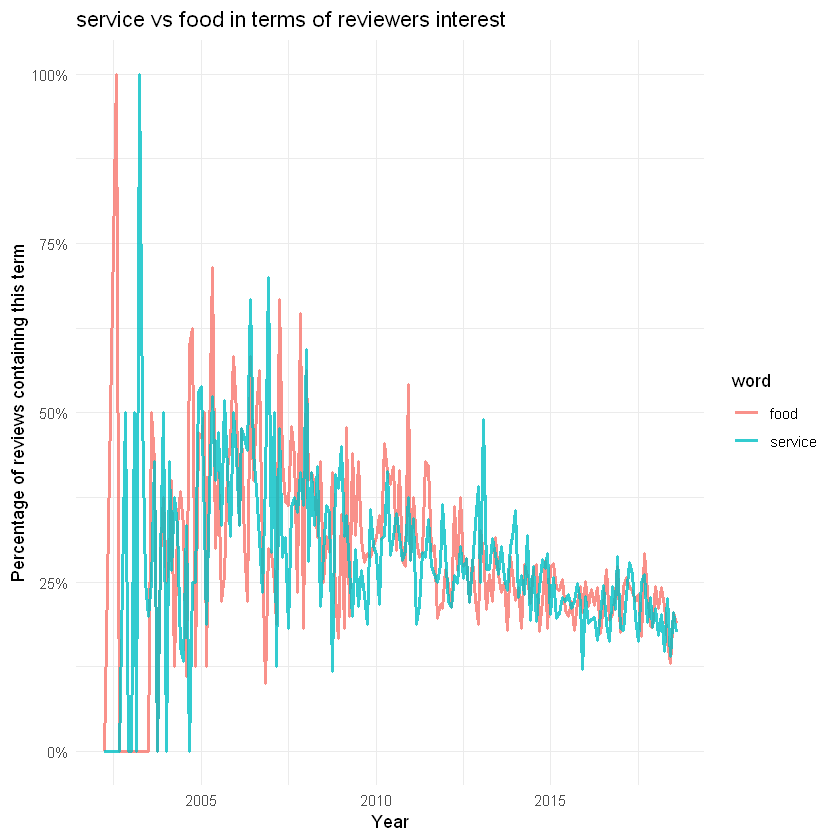

In [21]:
word_month_counts %>%
  filter(word %in% c("service", "food")) %>%
  ggplot(aes(month, n / month_total, color = word)) +
  geom_line(size = 1, alpha = .8) +
  scale_y_continuous(labels = percent_format()) +
  expand_limits(y = 0) +
  labs(x = "Year",
       y = "Percentage of reviews containing this term", title = "service vs food in terms of reviewers interest")

## Sentiment Analysis

Joining, by = "word"

Joining, by = "word"

Selecting by n



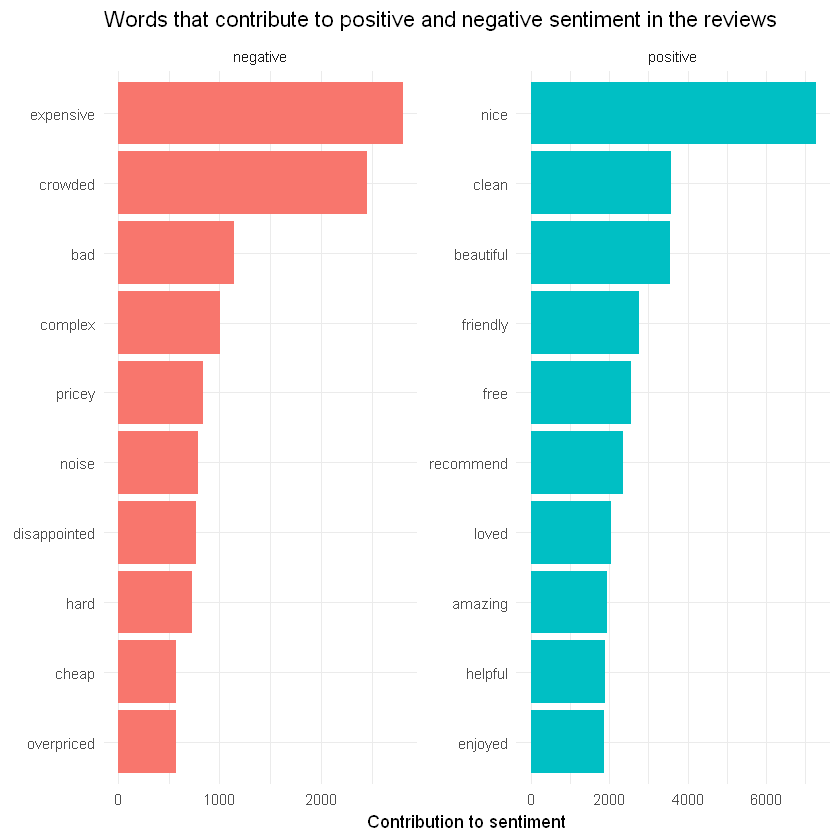

In [22]:
reviews <- df %>% 
  filter(!is.na(review_body)) %>% 
  select(ID, review_body) %>% 
  group_by(row_number()) %>% 
  ungroup()
tidy_reviews <- reviews %>%
  unnest_tokens(word, review_body)
tidy_reviews <- tidy_reviews %>%
  anti_join(stop_words)

bing_word_counts <- tidy_reviews %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()

bing_word_counts %>%
  group_by(sentiment) %>%
  top_n(10) %>%
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free") +
  labs(y = "Contribution to sentiment", x = NULL) +
  coord_flip() + 
  ggtitle('Words that contribute to positive and negative sentiment in the reviews')


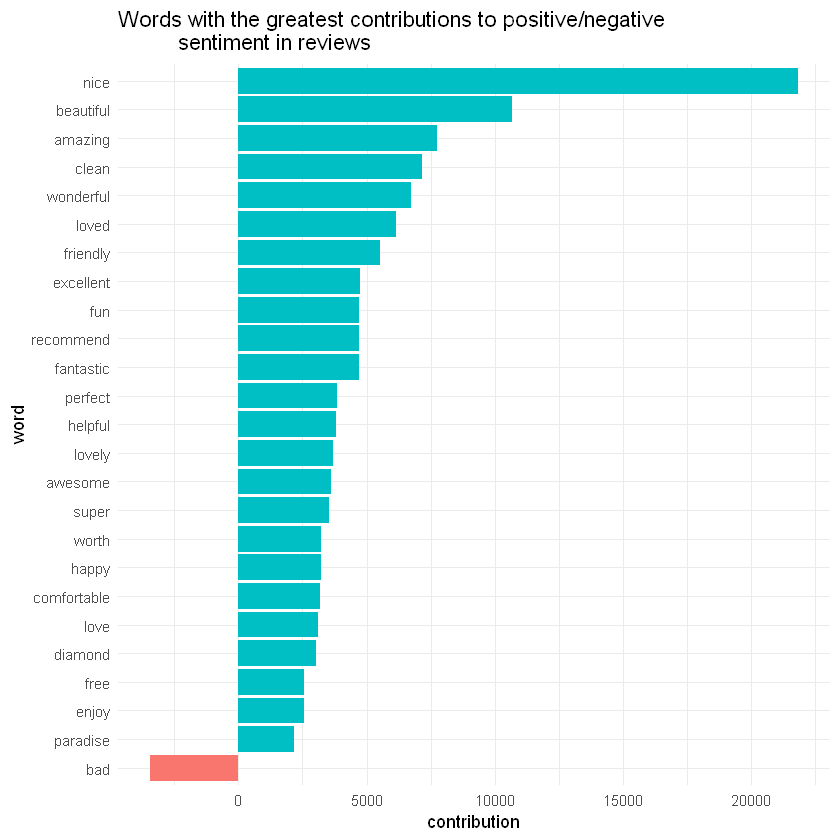

In [23]:
contributions <- tidy_reviews %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  group_by(word) %>%
  summarize(occurences = n(),
            contribution = sum(score))
contributions %>%
  top_n(25, abs(contribution)) %>%
  mutate(word = reorder(word, contribution)) %>%
  ggplot(aes(word, contribution, fill = contribution > 0)) +
  ggtitle('Words with the greatest contributions to positive/negative 
          sentiment in reviews') +
  geom_col(show.legend = FALSE) +
  coord_flip()


## Using Bigrams to Provide Context in Sentiment Analysis

In [24]:
bigrams_separated %>%
  filter(word1 == "not") %>%
  count(word1, word2, sort = TRUE)

word1,word2,n
<chr>,<chr>,<int>
not,a,850
not,the,698
not,have,582
not,to,414
not,be,384
not,sure,356
not,as,279
not,very,270
not,worth,242


In [25]:
AFINN <- get_sentiments("afinn")
not_words <- bigrams_separated %>%
  filter(word1 == "not") %>%
  inner_join(AFINN, by = c(word2 = "word")) %>%
  count(word2, score, sort = TRUE) %>%
  ungroup()

not_words

word2,score,n
<chr>,<int>,<int>
worth,2,242
recommend,2,147
like,2,145
want,1,129
great,3,127
good,3,115
bad,-3,85
happy,3,55
impressed,3,52


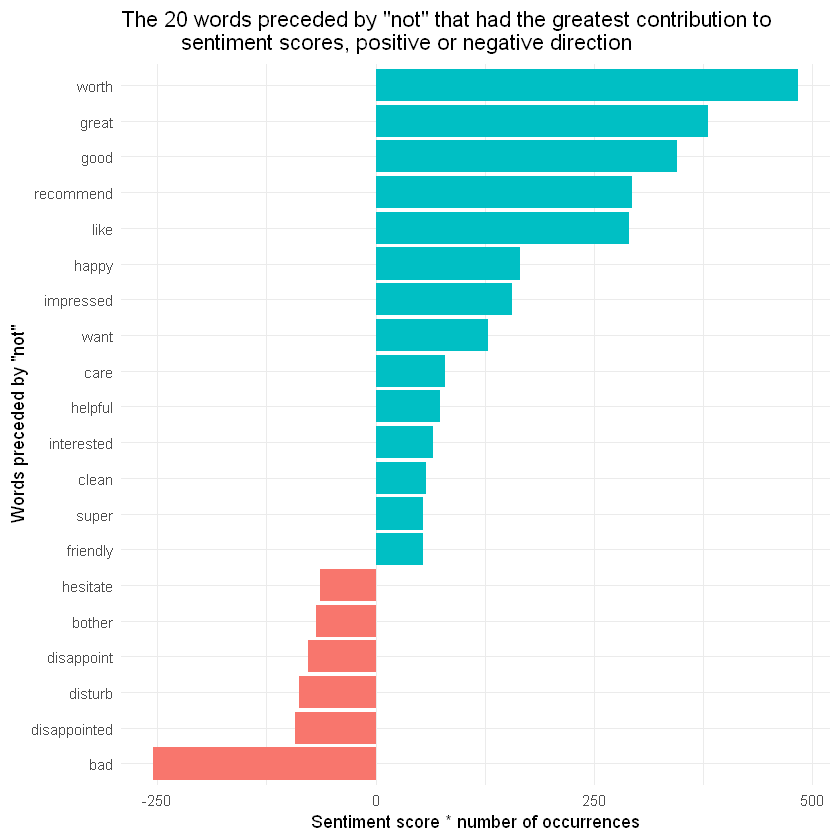

In [26]:
not_words %>%
  mutate(contribution = n * score) %>%
  arrange(desc(abs(contribution))) %>%
  head(20) %>%
  mutate(word2 = reorder(word2, contribution)) %>%
  ggplot(aes(word2, n * score, fill = n * score > 0)) +
  geom_col(show.legend = FALSE) +
  xlab("Words preceded by \"not\"") +
  ylab("Sentiment score * number of occurrences") +
  ggtitle('The 20 words preceded by "not" that had the greatest contribution to 
          sentiment scores, positive or negative direction') +
  coord_flip()

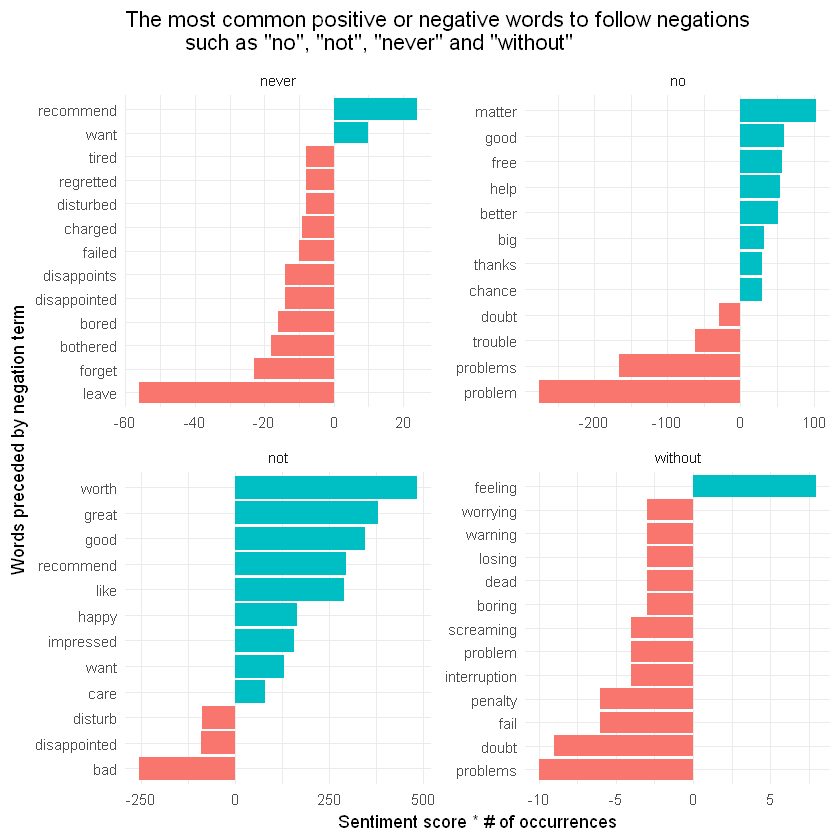

In [27]:
negation_words <- c("not", "no", "never", "without")

negated_words <- bigrams_separated %>%
  filter(word1 %in% negation_words) %>%
  inner_join(AFINN, by = c(word2 = "word")) %>%
  count(word1, word2, score, sort = TRUE) %>%
  ungroup()

negated_words %>%
  mutate(contribution = n * score,
         word2 = reorder(paste(word2, word1, sep = "__"), contribution)) %>%
  group_by(word1) %>%
  top_n(12, abs(contribution)) %>%
  ggplot(aes(word2, contribution, fill = n * score > 0)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ word1, scales = "free") +
  scale_x_discrete(labels = function(x) gsub("__.+$", "", x)) +
  xlab("Words preceded by negation term") +
  ylab("Sentiment score * # of occurrences") +
  ggtitle('The most common positive or negative words to follow negations 
          such as "no", "not", "never" and "without"') +
  coord_flip()

###  find out the most positive and negative reviews.

In [28]:
sentiment_messages <- tidy_reviews %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  group_by(ID) %>%
  summarize(sentiment = mean(score),
            words = n()) %>%
  ungroup() %>%
  filter(words >= 5)
sentiment_messages %>%
  arrange(desc(sentiment))

ID,sentiment,words
<int>,<dbl>,<int>
2363,4.000000,7
2578,3.800000,5
3629,3.800000,5
13692,3.800000,5
1039,3.714286,7
1332,3.714286,7
12954,3.714286,7
4909,3.666667,6
5768,3.666667,6


In [29]:
df[ which(df$ID==2363), ]$review_body[1]

[1] "Wow wow wow what a place we had a fantastic time and amazing views from our room. The Hilton is just fantastic This Hotel is amazing for everyone from kids to adults it has everything you will ever need."

In [30]:
sentiment_messages %>%
  arrange(sentiment)

ID,sentiment,words
<int>,<dbl>,<int>
3748,-3.600000,5
317,-2.800000,5
7135,-2.600000,5
10498,-2.600000,5
2766,-2.285714,7
10656,-2.285714,7
24,-2.200000,5
9161,-2.200000,5
12080,-2.200000,5


In [31]:
df[ which(df$ID==3748), ]$review_body[1]

[1] "Stayed here for 5 nights 5/12/16 - 5/17/16. The first night we noticed one of the floor tiles broke and kids were playing with their fingers. The second night we start seeing small cock roaches crawling on our baby's food. The front desk offered new room however they request is to move within 1 hour, otherwise they can't let us switch... It was late in the night 11pm, we all tired and babies were already sleep. We decline the offer. When checkout, the front counter lady told me cock roaches are common in this hotel rooms. And asked me California don't have any cock roaches? This is way beyond my expectation for Hilton."